In [1]:
#colab only!
from google.colab import drive
import os
drive.mount('/content/drive', force_remount=True)
os.chdir('/content/drive/MyDrive/CSE8803IUQ_TermProject')


Mounted at /content/drive


In [2]:
%load_ext autoreload
%autoreload 2


In [3]:
!pip3 install -r requirements.txt
!pip3 install gdown
!mkdir data && cd data
!gdown 1WUgfFip5xvxQV-RqWRaHCRYuCwqBCGL7
!unzip preprocessed.zip


mkdir: cannot create directory ‘data’: File exists
Downloading...
From (original): https://drive.google.com/uc?id=1WUgfFip5xvxQV-RqWRaHCRYuCwqBCGL7
From (redirected): https://drive.google.com/uc?id=1WUgfFip5xvxQV-RqWRaHCRYuCwqBCGL7&confirm=t&uuid=db800ffd-8d2f-444a-80fe-826ee397f438
To: /content/drive/MyDrive/CSE8803IUQ_TermProject/preprocessed.zip
100% 164M/164M [00:02<00:00, 58.1MB/s]
Archive:  preprocessed.zip
replace preprocessed/Atlantic Spotted Dolphin/61025001.pt? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [4]:
import numpy as np
import os
import torch
from torch.utils.data import Dataset, DataLoader
import glob
from tqdm import tqdm
from dataset import create_datasets
from baseline_model import MarineMammalInceptionNet
from evaluation import evaluate_model, plot_calibration_curve, evaluate_dropout

## Load dataset and initialize model. Use seed=42 to split train/test

Scanning directories...


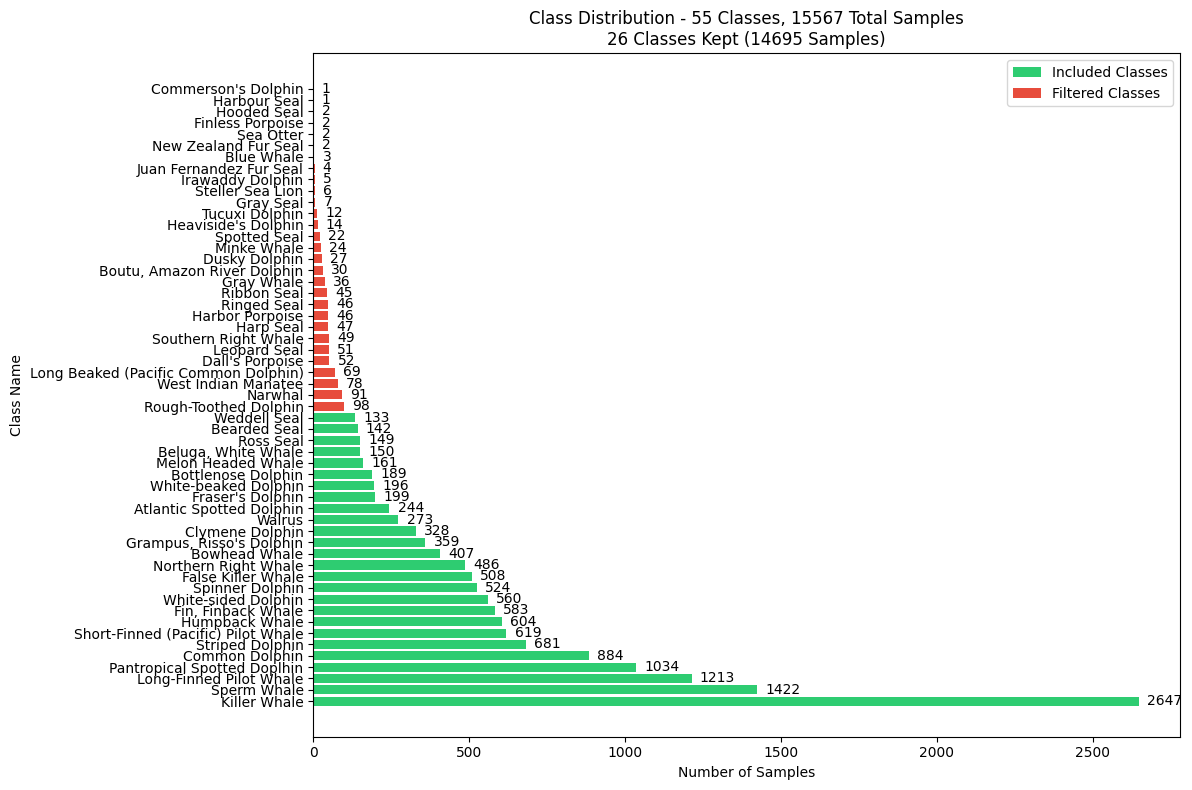

<Figure size 1200x1650 with 0 Axes>

Dataset Summary:
  - Total classes: 55
  - Classes meeting min_samples threshold: 26
  - Total samples: 15567
  - Kept samples: 14695 (94.4%)
  - Min samples per class: 1
  - Max samples per class: 2647
  - Avg samples per class: 283.0
Class distribution in split:
  - Atlantic Spotted Dolphin: Train 195/244 (79.9%), Test 49/244 (20.1%)
  - Bearded Seal: Train 114/142 (80.3%), Test 28/142 (19.7%)
  - Beluga, White Whale: Train 120/150 (80.0%), Test 30/150 (20.0%)
  - Bottlenose Dolphin: Train 151/189 (79.9%), Test 38/189 (20.1%)
  - Bowhead Whale: Train 326/407 (80.1%), Test 81/407 (19.9%)
  - Clymene Dolphin: Train 262/328 (79.9%), Test 66/328 (20.1%)
  - Common Dolphin: Train 707/884 (80.0%), Test 177/884 (20.0%)
  - False Killer Whale: Train 407/508 (80.1%), Test 101/508 (19.9%)
  - Fin, Finback Whale: Train 466/583 (79.9%), Test 117/583 (20.1%)
  - Fraser's Dolphin: Train 159/199 (79.9%), Test 40/199 (20.1%)
  - Grampus, Risso's Dolphin: Train 287/359 (79.9%), Test 72/359 (20.1%)
  

100%|██████████| 11756/11756 [00:40<00:00, 293.63it/s]


Computing normalization parameters...
Normalization parameters:
  - Mean: tensor([2.8113])
  - Std: tensor([12.4482])
Loading 2939 tensors into memory...


100%|██████████| 2939/2939 [00:08<00:00, 354.83it/s]


In [5]:
root_dir = "preprocessed"
split_seed = 42
# Keep only labels with at least 100 examples
train_dataset, test_dataset, class_to_idx = create_datasets(
    root_dir=root_dir,
    test_size=0.2,
    min_samples=100,
    random_state=split_seed
)

class_weights = train_dataset.get_class_weights()
num_classes = len(class_to_idx)

In [6]:
model = MarineMammalInceptionNet(num_classes, dropoutProbs = 0.5)

In [7]:
# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=3072, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=3072, shuffle=False, num_workers=2)

## Training

In [8]:
# Example training setup
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn as nn
from torch.optim.lr_scheduler import OneCycleLR

# Move model to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

num_epochs = 1000

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)

# Calculate total steps for the scheduler
total_steps = len(train_loader) * num_epochs

# Define the learning rate scheduler
scheduler = OneCycleLR(
    optimizer,
    max_lr=0.01,  # Maximum learning rate at the peak of the cycle
    total_steps=total_steps,
    pct_start=0.3,  # Percentage of steps spent in the increasing phase
    anneal_strategy='cos',  # Cosine annealing for decreasing phase
    div_factor=25.0,  # Initial learning rate = max_lr/div_factor
    final_div_factor=1000.0  # Final learning rate = initial_lr/final_div_factor
)

In [9]:
import time
import torch
import datetime

# Training loop with time and GPU memory tracking
start_time = time.time()

for epoch in range(num_epochs):
    epoch_start = time.time()
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Step the scheduler (OneCycleLR is updated per batch)
        scheduler.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    epoch_time = time.time() - epoch_start

    # Get GPU memory usage
    gpu_memory_used = 0
    if torch.cuda.is_available():
        # Get current GPU memory usage in MB
        gpu_memory_used = torch.cuda.max_memory_allocated() / (1024 ** 2)
        # Reset peak memory stats for next epoch
        torch.cuda.reset_peak_memory_stats()

    # Get current learning rate
    current_lr = scheduler.get_last_lr()[0]

    # Format time as hours:minutes:seconds
    epoch_time_str = str(datetime.timedelta(seconds=int(epoch_time)))
    total_time_str = str(datetime.timedelta(seconds=int(time.time() - start_time)))

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, LR: {current_lr:.6f}, Time: {epoch_time_str}, GPU Memory: {gpu_memory_used:.1f} MB, Total Time: {total_time_str}')

# Report final training statistics
total_training_time = time.time() - start_time
print(f'Finished Training in {str(datetime.timedelta(seconds=int(total_training_time)))}')
torch.save(model.state_dict(), "checkpoints/baseline_model_small.pth")

Epoch 1/1000, Loss: 3.2817, LR: 0.000400, Time: 0:00:03, GPU Memory: 12085.5 MB, Total Time: 0:00:03
Epoch 2/1000, Loss: 3.2055, LR: 0.000401, Time: 0:00:03, GPU Memory: 11140.7 MB, Total Time: 0:00:07
Epoch 3/1000, Loss: 3.1638, LR: 0.000402, Time: 0:00:03, GPU Memory: 11140.7 MB, Total Time: 0:00:10
Epoch 4/1000, Loss: 3.1134, LR: 0.000404, Time: 0:00:03, GPU Memory: 11140.7 MB, Total Time: 0:00:13
Epoch 5/1000, Loss: 3.0579, LR: 0.000407, Time: 0:00:03, GPU Memory: 11140.7 MB, Total Time: 0:00:16
Epoch 6/1000, Loss: 2.9961, LR: 0.000409, Time: 0:00:03, GPU Memory: 11140.7 MB, Total Time: 0:00:19
Epoch 7/1000, Loss: 2.9401, LR: 0.000413, Time: 0:00:03, GPU Memory: 11140.7 MB, Total Time: 0:00:23
Epoch 8/1000, Loss: 2.8709, LR: 0.000417, Time: 0:00:03, GPU Memory: 11140.7 MB, Total Time: 0:00:26
Epoch 9/1000, Loss: 2.8127, LR: 0.000421, Time: 0:00:03, GPU Memory: 11140.7 MB, Total Time: 0:00:29
Epoch 10/1000, Loss: 2.7373, LR: 0.000426, Time: 0:00:03, GPU Memory: 11140.7 MB, Total Tim

## Inference and evaluation - Base Model

In [13]:
print("Evaluating on training set...")
train_metrics = evaluate_model(model, train_loader, device)

# Evaluate on test set
print("\nEvaluating on test set...")
test_metrics = evaluate_model(model, test_loader, device)

# Print metrics
print("\n===== Training Set Metrics =====")
print(f"Accuracy: {train_metrics['accuracy']:.4f}")
print(f"Precision: {train_metrics['precision']:.4f}")
print(f"Recall: {train_metrics['recall']:.4f}")
print(f"F1 Score: {train_metrics['f1']:.4f}")
print(f"Expected Calibration Error: {train_metrics['ece']:.4f}")
print(f"Mean Entropy: {train_metrics['mean_entropy']:.4f}")
print(f"Inference Time: {str(datetime.timedelta(seconds=int(train_metrics['inference_time'])))}")
print(f"Inference Time per Sample: {train_metrics['inference_time_per_sample']*1000:.2f} ms")

print("\n===== Test Set Metrics =====")
print(f"Accuracy: {test_metrics['accuracy']:.4f}")
print(f"Precision: {test_metrics['precision']:.4f}")
print(f"Recall: {test_metrics['recall']:.4f}")
print(f"F1 Score: {test_metrics['f1']:.4f}")
print(f"Expected Calibration Error: {test_metrics['ece']:.4f}")
print(f"Mean Entropy: {test_metrics['mean_entropy']:.4f}")
print(f"Inference Time: {str(datetime.timedelta(seconds=int(test_metrics['inference_time'])))}")
print(f"Inference Time per Sample: {test_metrics['inference_time_per_sample']*1000:.2f} ms")

Evaluating on training set...

Evaluating on test set...

===== Training Set Metrics =====
Accuracy: 0.9849
Precision: 0.9867
Recall: 0.9849
F1 Score: 0.9849
Expected Calibration Error: 0.0050
Mean Entropy: 0.0204
Inference Time: 0:00:01
Inference Time per Sample: 0.14 ms

===== Test Set Metrics =====
Accuracy: 0.8602
Precision: 0.8621
Recall: 0.8602
F1 Score: 0.8599
Expected Calibration Error: 0.1005
Mean Entropy: 0.1040
Inference Time: 0:00:00
Inference Time per Sample: 0.16 ms


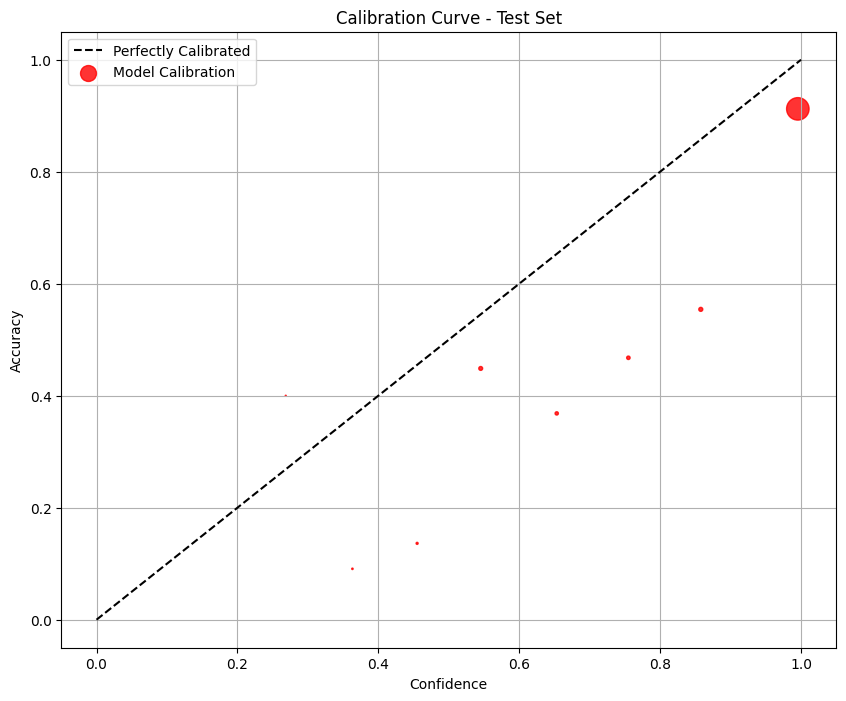

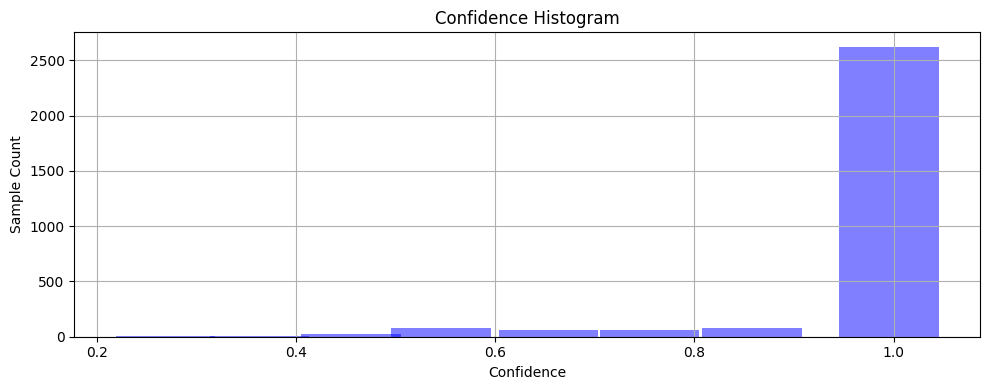

In [14]:
# Plot calibration curve for test set
plot_calibration_curve(
    test_metrics['bin_accuracies'],
    test_metrics['bin_confidences'],
    test_metrics['bin_counts'],
    'Calibration Curve - Test Set'
)

# Inference & Evaluation - MC Dropout

In [16]:


print("Evaluating on training set...")
train_metrics = evaluate_dropout(model, train_loader, 100, device)
# Evaluate on test set
print("\nEvaluating on test set...")
test_metrics = evaluate_dropout(model, test_loader, 100, device)

# Print metrics
print("\n===== Training Set Metrics =====")
print(f"Accuracy: {train_metrics['accuracy']:.4f}")
print(f"Precision: {train_metrics['precision']:.4f}")
print(f"Recall: {train_metrics['recall']:.4f}")
print(f"F1 Score: {train_metrics['f1']:.4f}")
print(f"Expected Calibration Error: {train_metrics['ece']:.4f}")
print(f"Mean Predictive Entropy: {train_metrics['mean_predictive_entropy']:.4f}")
print(f"Mean Mutual Information: {train_metrics['mean_mutual_information']:.4f}")
print(f"Mean Probability Variance: {train_metrics['mean_prob_variance']:.4f}")
print(f"Inference Time: {str(datetime.timedelta(seconds=int(train_metrics['inference_time'])))}")
print(f"Inference Time per Sample: {train_metrics['inference_time_per_sample']*1000:.2f} ms")

print("\n===== Test Set Metrics =====")
print(f"Accuracy: {test_metrics['accuracy']:.4f}")
print(f"Precision: {test_metrics['precision']:.4f}")
print(f"Recall: {test_metrics['recall']:.4f}")
print(f"F1 Score: {test_metrics['f1']:.4f}")
print(f"Expected Calibration Error: {test_metrics['ece']:.4f}")
print(f"Mean Predictive Entropy: {test_metrics['mean_predictive_entropy']:.4f}")
print(f"Mean Mutual Information: {test_metrics['mean_mutual_information']:.4f}")
print(f"Mean Probability Variance: {test_metrics['mean_prob_variance']:.4f}")
print(f"Inference Time: {str(datetime.timedelta(seconds=int(test_metrics['inference_time'])))}")
print(f"Inference Time per Sample: {test_metrics['inference_time_per_sample']*1000:.2f} ms")

Evaluating on training set...

Evaluating on test set...

===== Training Set Metrics =====
Accuracy: 0.9849
Precision: 0.9867
Recall: 0.9849
F1 Score: 0.9850
Expected Calibration Error: 0.0104
Mean Predictive Entropy: 0.0631
Mean Mutual Information: 0.0256
Mean Probability Variance: 0.0002
Inference Time: 0:01:30
Inference Time per Sample: 7.73 ms

===== Test Set Metrics =====
Accuracy: 0.8568
Precision: 0.8576
Recall: 0.8568
F1 Score: 0.8561
Expected Calibration Error: 0.0362
Mean Predictive Entropy: 0.3281
Mean Mutual Information: 0.1914
Mean Probability Variance: 0.0031
Inference Time: 0:00:22
Inference Time per Sample: 7.74 ms


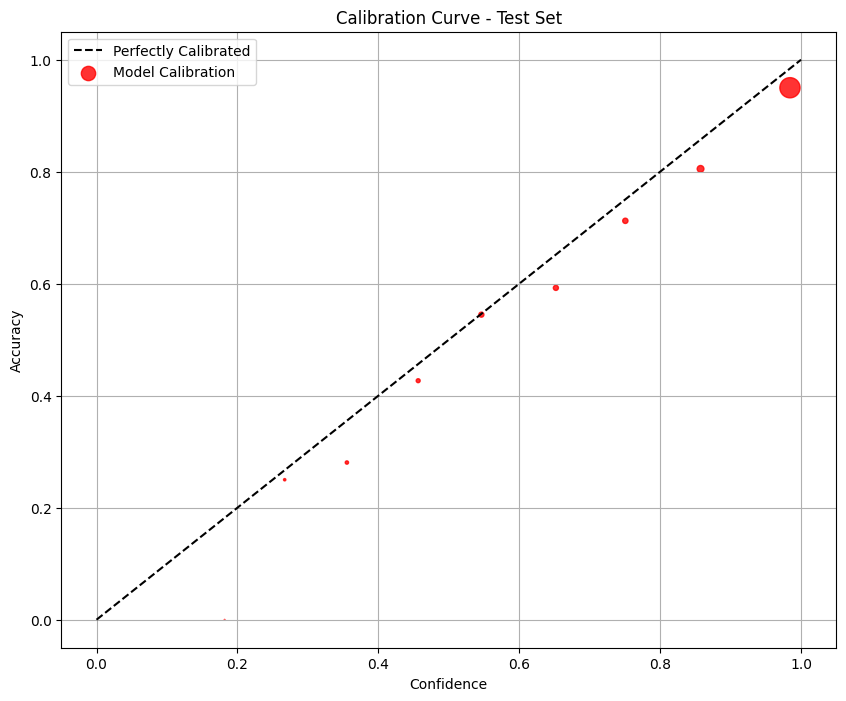

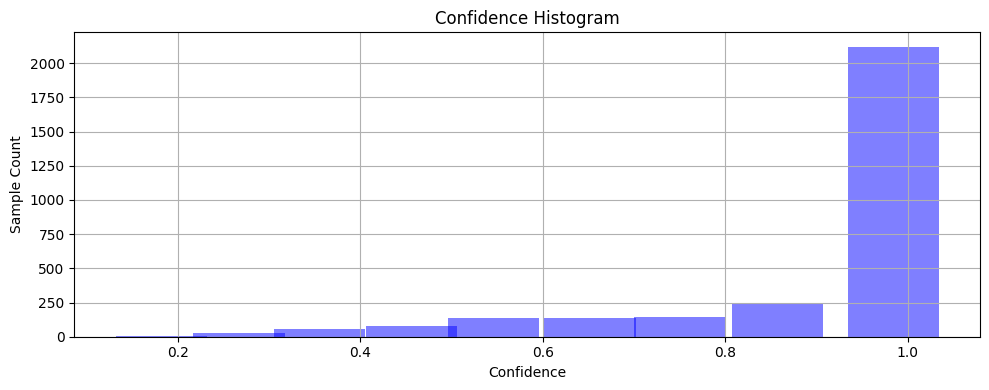

In [17]:
# Plot calibration curve for test set
plot_calibration_curve(
    test_metrics['bin_accuracies'],
    test_metrics['bin_confidences'],
    test_metrics['bin_counts'],
    'Calibration Curve - Test Set'
)